In [1]:
import numpy as np
import os
import pytorch_lightning as pl

import sys
sys.path.append('/work/ka1176/caroline/gitlab/2022-03-hereon-python-fortran-bridges/cffi_interface')
from solvers.moment_solver import simulation_forecast
import models.plModel as plm

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

/home/k/k202141/.conda/envs/iconml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

In [3]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [4]:
from importlib import reload
reload(plm)

<module 'models.plModel' from '/work/ka1176/caroline/gitlab/2022-03-hereon-python-fortran-bridges/cffi_interface/models/plModel.py'>

In [5]:
inputs_mean = np.asarray([[0.0002621447787797809, 51128093.51524663,
                    0.0003302890736022656, 5194.251154308974,
                    0.5566250557023539, 4.8690682855354596e-12,
                    0.0005924338523807814, 1.0848856769219835e-05,
                    2.0193905073168525]])

inputs_std = np.asarray([[0.0003865559774857862, 86503916.13808665,
                    0.00041369562655559327, 19127.947970150628,
                    0.46107363560819126, 3.873092422358367e-12,
                    0.00042887039563850967, 1.920461805101116e-06,
                    1.3098055608321857]])

updates_mean = np.asarray([[-8.527820407019667e-08, -13961.459867976775,
                    8.527678028525988e-08, 0.010221931180955181]])

updates_std = np.asarray([[3.600841676033818e-07, 55095.904252313965,
                    3.6008419243808887e-07, 68.6678997504877]])

#NN Model initalization
pl_model = plm.LightningModel(inputs_mean=inputs_mean, inputs_std=inputs_std,
                            updates_mean=updates_mean, updates_std=updates_std, use_dropout=False) 

model_path = '/work/ka1176/caroline/gitlab/2022-03-hereon-python-fortran-bridges/cffi_interface'
trained_model = pl_model.load_from_checkpoint(model_path + "/trained_models/best_model.ckpt")

In [6]:
trained_model.model.use_dropout

True

In [39]:
input_shape = (4, 1, 32)

In [40]:
moments_in = np.zeros(input_shape)
moments_in[0, :] = 1.0e-3
moments_in[1, :] = 1e8

swapped_moments = np.swapaxes(moments_in, 0, 2).reshape(-1, 4)

In [42]:
%%timeit
new_forecast = simulation_forecast(
            swapped_moments, trained_model, inputs_mean, inputs_std, updates_mean, updates_std
            )
new_forecast.test()

356 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
moments_out = new_forecast.moments_out
moments_out = np.swapaxes(moments_out, 0, 1)
moments_out = moments_out.reshape(input_shape)
print(moments_in.shape, moments_out.shape)

(4, 1, 16) (4, 1, 16)


In [11]:
## In vs out moments

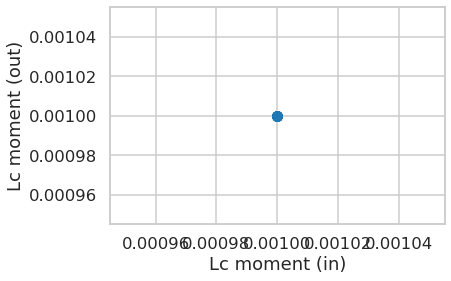

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(moments_in[0, 0], moments_out[0, 0])
ax.set_xlabel('Lc moment (in)')
ax.set_ylabel('Lc moment (out)')
plt.show()

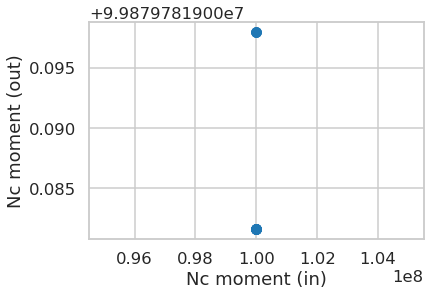

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(moments_in[1, 0], moments_out[1, 0])
ax.set_xlabel('Nc moment (in)')
ax.set_ylabel('Nc moment (out)')
plt.show()

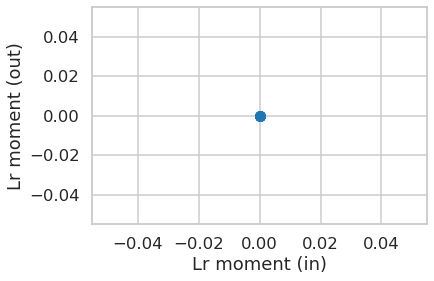

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(moments_in[2, 0], moments_out[2, 0])
ax.set_xlabel('Lr moment (in)')
ax.set_ylabel('Lr moment (out)')
plt.show()

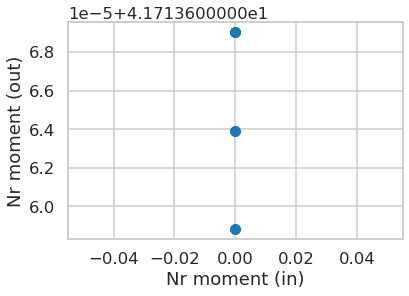

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(moments_in[3, 0], moments_out[3, 0])
ax.set_xlabel('Nr moment (in)')
ax.set_ylabel('Nr moment (out)')
plt.show()

In [16]:
c_tstep = []
c_type  = []
c_i     = []
c_k     = []
c_qc    = []

c_nc    = []
c_qr    = []
c_nr    = []

In [17]:
with open('/work/ka1176/caroline/gitlab/icon-aes/run/saved_fortran_moments') as f:
    tstep = 0
    #
    line = f.readline()
    while line:
                
        if 'model time' in line:
            tstep = int(line.split()[3])
            print('Model time step', tstep)
            
        if tstep > 41:
            break
        
        if 'm_in' in line:
            ll = np.array(line.replace(',','').split())
            vv = ll[[-14, -13]].astype(int)
            
            try:
                c_qr.append(float(ll[-4]))
                c_type.append('in')
                c_tstep.append(tstep)
                c_i.append(int(ll[-14]))
                c_k.append(int(ll[-13]))
                c_qc.append(float(ll[-10]))
                c_nc.append(float(ll[-7]))
                c_nr.append(float(ll[-1]))
                        
            except:
                
                pass # just ignore
            #print(df_fmom)
            #break
            
        line = f.readline()        
    

Model time step 1
Model time step 2
Model time step 3
Model time step 4
Model time step 5
Model time step 6
Model time step 7
Model time step 8
Model time step 9
Model time step 10
Model time step 11
Model time step 12
Model time step 13
Model time step 14
Model time step 15
Model time step 16
Model time step 17
Model time step 18
Model time step 19
Model time step 20
Model time step 21
Model time step 22
Model time step 23
Model time step 24
Model time step 25
Model time step 26
Model time step 27
Model time step 28
Model time step 29
Model time step 30
Model time step 31
Model time step 32
Model time step 33
Model time step 34
Model time step 35
Model time step 36
Model time step 37
Model time step 38
Model time step 39
Model time step 40
Model time step 41
Model time step 42


In [18]:
len(c_tstep), len(c_type), len(c_i), len(c_k), len(c_qc), len(c_nc), len(c_qr)

(352, 352, 352, 352, 352, 352, 352)

In [19]:
df_fmom = pd.DataFrame(dict(tstep=c_tstep,
                            mode=c_type,
                            i=c_i,
                            k=c_k,
                            qc=c_qc,
                            nc=c_nc,
                            qr=c_qr,
                            nr=c_nr))
df_fmom

,tstep,mode,i,k,qc,nc,qr,nr
0,40,in,1,52,0.0,0.0,7.760124e-19,0.596345
1,40,in,2,52,0.0,0.0,7.760124e-19,0.596345
2,40,in,3,52,0.0,0.0,7.760124e-19,0.596345
3,40,in,1,53,0.0,0.0,6.546615e-17,1.807317
4,40,in,2,53,0.0,0.0,6.546615e-17,1.807317
...,...,...,...,...,...,...,...,...
347,40,in,4,54,0.0,0.0,2.281489e-16,2.469361
348,40,in,1,55,0.0,0.0,2.114677e-17,1.362514
349,40,in,2,55,0.0,0.0,2.114677e-17,1.362514
350,40,in,3,55,0.0,0.0,2.114677e-17,1.362514


In [20]:
df_first_tstep = df_fmom[df_fmom['tstep']==40]

In [21]:
df_fmom = df_fmom[(df_fmom[['qc', 'qr', 'nc', 'nr']] < 1e-14).sum(axis=1)<4]
df_fmom

,tstep,mode,i,k,qc,nc,qr,nr
0,40,in,1,52,0.0,0.0,7.760124e-19,0.596345
1,40,in,2,52,0.0,0.0,7.760124e-19,0.596345
2,40,in,3,52,0.0,0.0,7.760124e-19,0.596345
3,40,in,1,53,0.0,0.0,6.546615e-17,1.807317
4,40,in,2,53,0.0,0.0,6.546615e-17,1.807317
...,...,...,...,...,...,...,...,...
347,40,in,4,54,0.0,0.0,2.281489e-16,2.469361
348,40,in,1,55,0.0,0.0,2.114677e-17,1.362514
349,40,in,2,55,0.0,0.0,2.114677e-17,1.362514
350,40,in,3,55,0.0,0.0,2.114677e-17,1.362514


## maximum input moments per time step

In [22]:
df_fmom_max = df_fmom.groupby('tstep')[['qc', 'qr', 'nc', 'nr', 'tstep']].max()

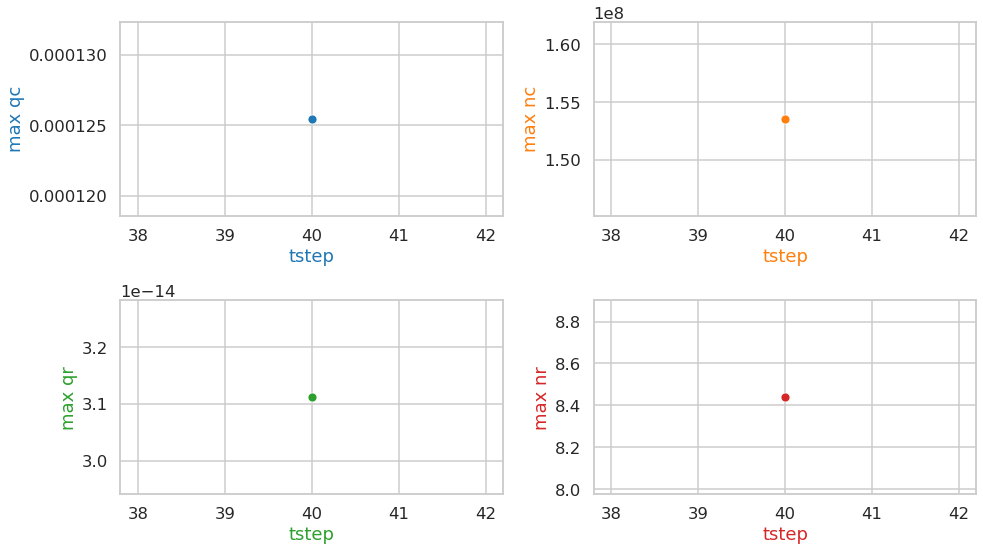

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, lbl, ax in zip(range(4), ['qc', 'nc', 'qr', 'nr'], axs):

    sns.lineplot(data=df_fmom_max, x='tstep', y=lbl, marker='o', color='C'+str(i), ax=ax)
    ax.set_ylabel('max ' + lbl, color='C'+str(i))
    ax.set_xlabel('tstep', color='C'+str(i))
fig.tight_layout()

In [24]:
max_moments = df_fmom_max[['qc', 'nc', 'qr', 'nr']].values

In [25]:
new_forecast = simulation_forecast(
            max_moments, trained_model, inputs_mean, inputs_std, updates_mean, updates_std
            )
new_forecast.test()

In [26]:
new_moments = new_forecast.moments_out

<ipython-input-27-2cf4d0424503>:5: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(max_moments[:, i]), np.log10(new_moments[:, i]), color='C'+str(i))


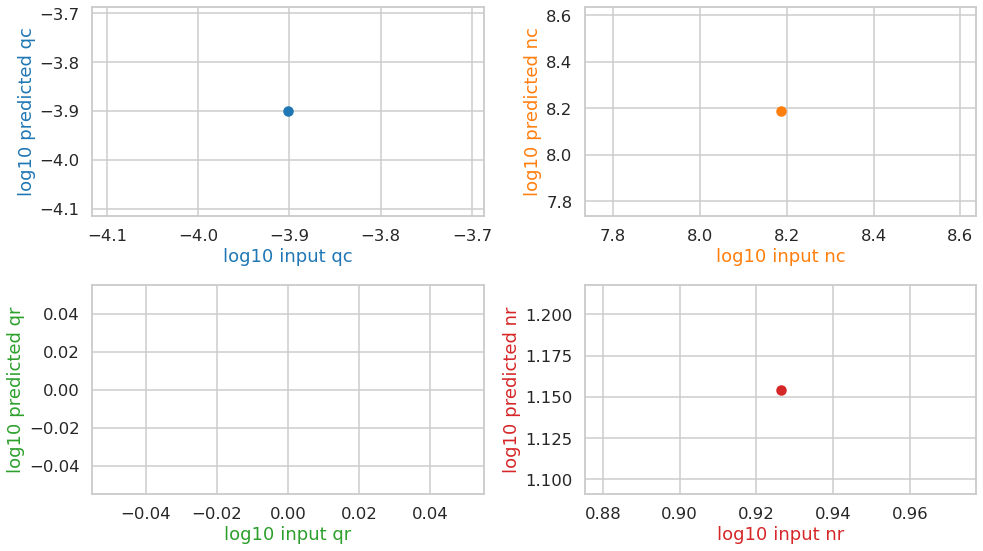

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, lbl, ax in zip(range(4), ['qc', 'nc', 'qr', 'nr'], axs):
    ax.scatter(np.log10(max_moments[:, i]), np.log10(new_moments[:, i]), color='C'+str(i))
    #sns.lineplot(data=df_fmom_max, x='tstep', y=lbl, marker='o', color='C'+str(i), ax=ax)
    ax.set_ylabel('log10 predicted ' + lbl, color='C'+str(i))
    ax.set_xlabel('log10 input ' + lbl, color='C'+str(i))

    fig.tight_layout()

## low values

In [28]:
df_fmom_min = df_fmom.groupby('tstep')[['qc', 'qr', 'nc', 'nr', 'tstep']].min()

In [29]:
min_moments = df_fmom_min[['qc', 'nc', 'qr', 'nr']].values

In [30]:
new_forecast = simulation_forecast(
            min_moments, trained_model, inputs_mean, inputs_std, updates_mean, updates_std
            )
new_forecast.test()

In [31]:
new_moments = new_forecast.moments_out

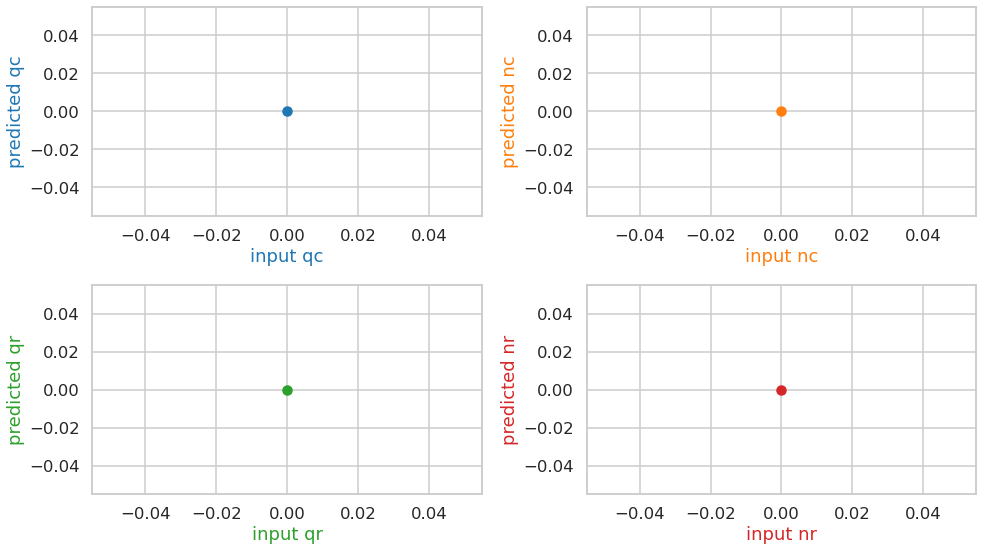

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, lbl, ax in zip(range(4), ['qc', 'nc', 'qr', 'nr'], axs):
    ax.scatter(min_moments[:, i], new_moments[:, i], color='C'+str(i))
    #sns.lineplot(data=df_fmom_max, x='tstep', y=lbl, marker='o', color='C'+str(i), ax=ax)
    ax.set_ylabel('predicted ' + lbl, color='C'+str(i))
    ax.set_xlabel('input ' + lbl, color='C'+str(i))

    fig.tight_layout()

/home/k/k202141/.conda/envs/iconml/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='nc', ylabel='Count'>

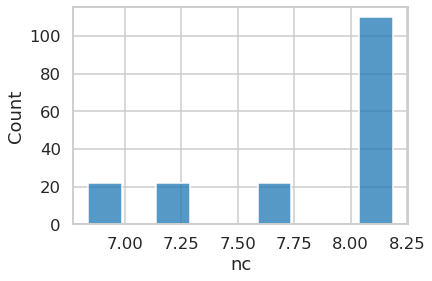

In [33]:
sns.histplot(np.log10(df_fmom['nc']))

## first non zero timestep

In [34]:
first_moms = df_first_tstep[['qc', 'nc', 'qr', 'nr']].values

In [35]:
new_forecast = simulation_forecast(
            first_moms, trained_model, inputs_mean, inputs_std, updates_mean, updates_std
            )
new_forecast.test()

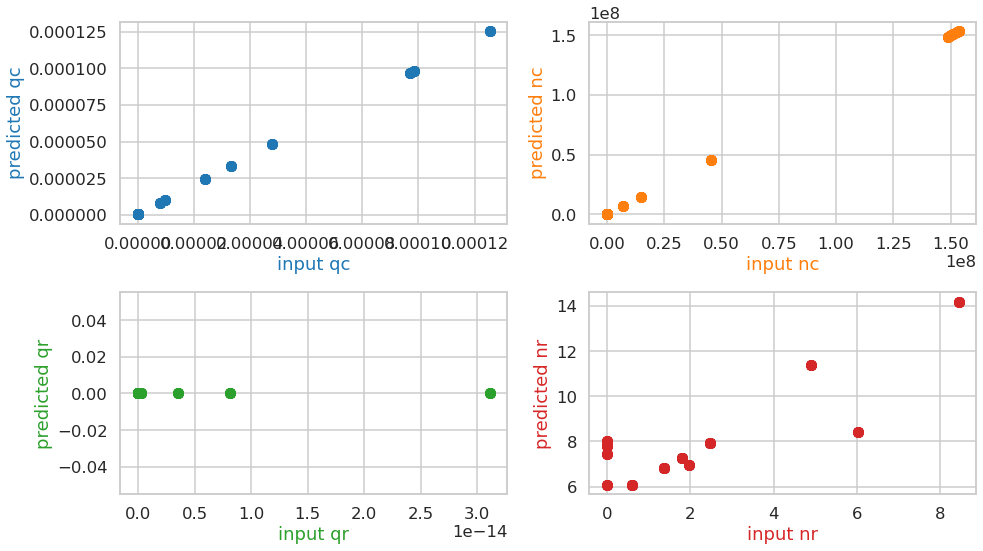

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, lbl, ax in zip(range(4), ['qc', 'nc', 'qr', 'nr'], axs):
    ax.scatter(first_moms[:, i], new_forecast.moments_out[:, i], color='C'+str(i))
    #sns.lineplot(data=df_fmom_max, x='tstep', y=lbl, marker='o', color='C'+str(i), ax=ax)
    ax.set_ylabel('predicted ' + lbl, color='C'+str(i))
    ax.set_xlabel('input ' + lbl, color='C'+str(i))

    fig.tight_layout()

In [37]:
pm = new_forecast.moments_out

In [38]:
df_fmom_out

NameError: name 'df_fmom_out' is not defined

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, lbl, ax in zip(range(4), ['qc', 'nc', 'qr', 'nr'], axs):
    ax.scatter(df_fmom_out[lbl], pm[:, i], color='C'+str(i))
    #sns.lineplot(data=df_fmom_max, x='tstep', y=lbl, marker='o', color='C'+str(i), ax=ax)
    ax.set_ylabel('predicted ' + lbl, color='C'+str(i))
    ax.set_xlabel('calculated ' + lbl, color='C'+str(i))
    
    xl = ax.get_xlim()
    print(xl)
    
    ax.plot(np.linspace(*xl), np.linspace(*xl), color='C7')

    fig.tight_layout()

## first non zero timestep - but one in the batch may be zero

In [ ]:
first_moms = df_first_tstep[['qc', 'nc', 'qr', 'nr']].values

#first_moms[100] = 0
first_moms[204] = 0

In [ ]:
print(first_moms[205])
print('*'*20)

for i in range(10):
    new_forecast = simulation_forecast(
            first_moms[205], trained_model, inputs_mean, inputs_std, updates_mean, updates_std
            )
    new_forecast.test()
    
    print(new_forecast.moments_out)

In [ ]:
np.isnan(new_forecast.moments_out).sum()

In [ ]:
np.log10(np.nanmax(new_forecast.moments_out))


In [ ]:
zero_ix = np.where(np.sum(np.abs(first_moms), axis=1) == 0)[0]
print(zero_ix)

In [ ]:
new_forecast.moments_out[100]

In [ ]:
first_moms[205], new_forecast.moments_out[205]

In [ ]:
input_batch = np.array([
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[7.77E-06, 1.48E+07, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[7.77E-06, 1.48E+07, 0.00E+00, 0.00E+00],
[7.77E-06, 1.48E+07, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00],
[7.77E-06, 1.48E+07, 0.00E+00, 0.00E+00]])


In [ ]:
for i in range(10):
    nf = simulation_forecast(
            input_batch, trained_model, inputs_mean, inputs_std, updates_mean, updates_std
            )
    nf.test()
    
    print(np.isnan(nf.moments_out).sum())
    print(np.max(nf.moments_out))
    
    if i == 0:
        pm0 = nf.moments_out
    else:
        assert np.allclose(nf.moments_out, pm0), print(pm0, print(nf.moments_out))
        pm0 = nf.moments_out


In [ ]:
pm0

In [ ]:
pm1

In [ ]:
import torch

def test(all_moments_in):
    
        inputs_mean = np.asarray([[0.0002621447787797809, 51128093.51524663,
                    0.0003302890736022656, 5194.251154308974,
                    0.5566250557023539, 4.8690682855354596e-12,
                    0.0005924338523807814, 1.0848856769219835e-05,
                    2.0193905073168525]])

        inputs_std = np.asarray([[0.0003865559774857862, 86503916.13808665,
                    0.00041369562655559327, 19127.947970150628,
                    0.46107363560819126, 3.873092422358367e-12,
                    0.00042887039563850967, 1.920461805101116e-06,
                    1.3098055608321857]])

        updates_mean = np.asarray([[-8.527820407019667e-08, -13961.459867976775,
                    8.527678028525988e-08, 0.010221931180955181]])

        updates_std = np.asarray([[3.600841676033818e-07, 55095.904252313965,
                    3.6008419243808887e-07, 68.6678997504877]])

        #setup()
        
        all_moments_in = all_moments_in.astype(np.float32)
        all_moments_in = all_moments_in.reshape(-1,4)
        
        
        #self.create_input()
        divisor = all_moments_in[:,2] + all_moments_in[:,0]
        tau = np.divide( all_moments_in[:,2], divisor, where=divisor!=0 )

        xc = all_moments_in[:,0] / (all_moments_in[:,1] + 1e-8)
        lo_arr = all_moments_in[:,2] + all_moments_in[:,0]
        rm = np.full((lo_arr.shape),13e-6)
        nu = np.full((lo_arr.shape),1)

        model_params = np.concatenate((lo_arr.reshape(-1,1),
                                            rm.reshape(-1,1), nu.reshape(-1,1)),
                                           axis=1)

        #self.model_params = np.asarray([self.lo,self.rm,self.nu])
        inputs = np.concatenate(
            (
                all_moments_in,
                tau.reshape(-1, 1),
                xc.reshape(-1, 1),
                model_params
            ),
            axis=1,
        )
        
        
        #     def calc_mean(self, no_norm, means, stds):
        inputs = (inputs - inputs_mean.reshape(-1,)) / inputs_std.reshape(
            -1,
        )

        inputs = np.float32(inputs)
        inputs_mean = np.float32(inputs_mean)
        inputs_std  = np.float32(inputs_std)
        
        
        
        
        #
        predictions_updates = trained_model.test_step(torch.from_numpy(inputs))
        
        #print(inputs.shape)
        
        #trained_model()
        
        #with torch.no_grad():
        #    preds = trained_model(torch.from_numpy(inputs).float())
        #print(preds)
        
        print(predictions_updates)
        #self.moment_calc(predictions_updates)

        #self.moments_out = self.moments_out.astype(np.float64)

In [ ]:
trained_model.model.use_dropout = False

In [ ]:
xx = torch.zeros(9)

with torch.no_grad():
    for i in range(10):
        print(trained_model.model(xx))

In [ ]:
for i in range(2):
    test(np.zeros([1,4]))